In [22]:
import os
import re
import sys
from pathlib import Path

import pandas as pd
import scanpy as sc
import anndata as ad

In [23]:
#p_dir = (Path().cwd().parents[0]).absolute()
p_dir = 'Y:\\coskun-lab\\Thomas\\11_snowflakes'

module_path = str(p_dir + "\\src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [24]:
#data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_dir = (p_dir + '\\data')

In [25]:
#spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph_external'
spatial_omics_folder = p_dir + '\\data' + '\\spatial_omics_graph_external'
#process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'
process_path = p_dir + '\\data' + '\\torch_graph_data'

# Read data

In [26]:
# Read all spadata info
datasets = []
paths = []
path_rois = []

# Loop through data
for (dirpath, dirnames, filenames) in os.walk(spatial_omics_folder):
    for name in sorted(filenames):
        if 'hdf5' not in name:
            continue
         
        # read adata
        data_name = name.split('.')[0]
        path = os.path.join(dirpath, name)
        if 'roi' not in name:
            datasets.append(data_name)
            paths.append(os.path.join(dirpath, name))
            path_rois.append(os.path.join(dirpath, data_name+'_roi.hdf5'))
            
df = pd.DataFrame({'Dataset': datasets, 'Path': paths, 'Path_ROI': path_rois})
df = df[df.Dataset!= 'Covid_IMC_2']

In [27]:
adata_dir = data_dir + '\\adata'
adatas = []
datasets = []

# Loop through data
for (dirpath, dirnames, filenames) in os.walk(adata_dir):
    for name in sorted(filenames):
        if 'h5ad' not in name:
            continue
        if name != 'breast.h5ad':
            continue
        
        # read adata
        data_name = name.split('.')[0]
        print(f'Processing Data {data_name}')   
        path = os.path.join(dirpath, name)
        
        adata = sc.read_h5ad(path)
        adata.obs['Data'] = data_name
        
        if 'Dataset' in adata.obs:
            for d in adata.obs.Dataset.unique():
                a = adata[adata.obs.Dataset == d]
                adatas.append(a)
                datasets.append(data_name+f'_{d}')
        else:
            adatas.append(adata)
            datasets.append(data_name)

Processing Data breast


C:\Users\eozturk7\AppData\Local\miniconda3\envs\torch_gpu2\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [28]:
adata = ad.concat(adatas)

In [29]:
adata.obs

,metabricId,core_id,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,SOM_nodes,pg_cluster,description,Data
0,MB-0000,1,527,1,161.83333,6.000000,6,24,Fibroblasts,breast
1,MB-0000,1,527,2,177.30435,15.539130,6,24,Fibroblasts,breast
2,MB-0000,1,527,3,293.51898,19.886076,6,24,Fibroblasts,breast
3,MB-0000,1,527,4,165.04347,22.210144,4,20,Fibroblasts CD68+,breast
4,MB-0000,1,527,5,108.88095,28.523809,6,24,Fibroblasts,breast
...,...,...,...,...,...,...,...,...,...,...
479839,MB-0921,1,381,2080,440.20001,582.400020,99,54,HR- CK7-,breast
479840,MB-0921,1,381,2081,447.57895,583.157900,83,28,HRlow CKlow,breast
479841,MB-0921,1,381,2082,403.16666,583.142880,67,45,HRlow CKlow,breast
479842,MB-0921,1,381,2083,308.53845,585.230770,20,21,Fibroblasts,breast


In [16]:
# Create foll dataframe
df_foll = pd.DataFrame(adata.obs.groupby(['Data', 'Foll']).size()).reset_index()
df_foll.columns = ['Dataset', 'Foll', 'Number of cells']
df_foll = df_foll[df_foll.Foll > 0]

# Get tissue type mapping
tissue_type = {k: 'Tonsil' for k in df_foll.Dataset.unique() if 'A' not in k}
df_foll['Tissue'] = df_foll['Dataset'].apply(lambda x: tissue_type.get(x, 'Adenoid'))

KeyError: 'Foll'

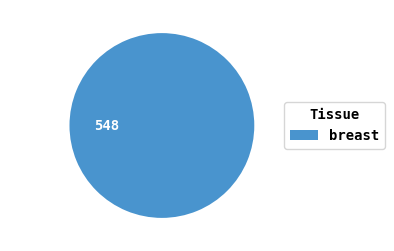

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#define data
data = df.groupby('Tissue').size().values
labels = df.groupby('Tissue').size().index.tolist()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]


def absolute_value(val):
    a  = np.round(val/100.*data.sum(), 0).astype(int)
    return a

#create pie chart
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, labels = labels, colors = [ '#4994CE', '#F27420'], autopct=absolute_value, textprops=dict(color="w"))
ax.legend(wedges, labels,
          title="Tissue",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


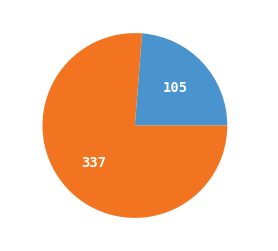

In [92]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#define data
data = df_foll[df_foll.Dataset.str.contains('07')].groupby('Tissue').size().values
labels = df_foll[df_foll.Dataset.str.contains('07')].groupby('Tissue').size().index.tolist()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]


def absolute_value(val):
    a  = np.round(val/100.*data.sum(), 0).astype(int)
    return a

#create pie chart
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, labels = labels, colors = [ '#4994CE', '#F27420'], autopct=absolute_value, textprops=dict(color="w"))

plt.show()


In [96]:
covid_map = {'07_A11': 'COVID+', '07_A18': 'COVID-', '07_A21': 'COVID-', '07_A22': 'COVID+',
       '07_A6': 'COVID-', '07_A8': 'COVID+', '07_T18': 'COVID-', '07_T22': 'COVID+', '07_T3': 'COVID-', '07_T5': 'COVID+', '07_T6': 'COVID-',
       '07_T8': 'COVID+'}

df_foll['COVID'] = df_foll.Dataset.map(lambda x: covid_map.get(x,x))

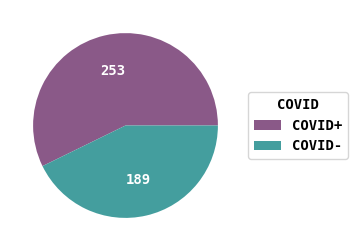

In [99]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#define data
data = df_foll[df_foll.Dataset.str.contains('07')].groupby('COVID').size().values
labels = df_foll[df_foll.Dataset.str.contains('07')].groupby('COVID').size().index.tolist()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]


def absolute_value(val):
    a  = np.round(val/100.*data.sum(), 0).astype(int)
    return a

#create pie chart
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, labels = labels, colors = ['#8A5988', '#449E9E'], autopct=absolute_value, textprops=dict(color="w"))
ax.legend(wedges, labels,
          title="COVID",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


### Stankey plot

In [100]:
df_cov = df_foll[df_foll.Dataset.str.contains('07')].groupby(['Tissue', 'COVID']).size()

In [101]:
df_cov

Tissue   COVID 
Adenoid  COVID+     58
         COVID-     47
Tonsil   COVID+    195
         COVID-    142
dtype: int64

In [103]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Original data
# data = [['Source','Target','Value','Color','Node, Label','Link Color'],
#     [0,5,20,'#F27420','Remain+No – 28','rgba(253, 227, 212, 0.5)'],
#     [0,6,3,'#4994CE','Leave+No – 16','rgba(242, 116, 32, 1)'],
#     [0,7,5,'#FABC13','Remain+Yes – 21','rgba(253, 227, 212, 0.5)'],
#     [1,5,14,'#7FC241','Leave+Yes – 14','rgba(219, 233, 246, 0.5)'],
#     [1,6,1,'#D3D3D3','Didn’t vote in at least one referendum – 21','rgba(73, 148, 206, 1)'],
#     [1,7,1,'#8A5988','46 – No','rgba(219, 233, 246,0.5)'],
#     [2,5,3,'#449E9E','39 – Yes','rgba(250, 188, 19, 1)'],
#     [2,6,17,'#D3D3D3','14 – Don’t know / would not vote','rgba(250, 188, 19, 0.5)'],
#     [2,7,2,'','','rgba(250, 188, 19, 0.5)'],
#     [3,5,3,'','','rgba(127, 194, 65, 1)'],
#     [3,6,9,'','','rgba(127, 194, 65, 0.5)'],
#     [3,7,2,'','','rgba(127, 194, 65, 0.5)'],
#     [4,5,5,'','','rgba(211, 211, 211, 0.5)'],
#     [4,6,9,'','','rgba(211, 211, 211, 0.5)'],
#     [4,7,8,'','','rgba(211, 211, 211, 0.5)']
#     ]

data = [['Source','Target','Value','Color','Node, Label','Link Color'],
    [0,2,195,'#F27420','Tonsil – 337', 'rgba(242, 116, 32, 0.75)'],
    [0,3,142,'#4994CE','Adenoid – 105', 'rgba(242, 116, 32, 0.75)'],
    [1,2,58,'#8A5988','253 – COVID+','rgba(73, 148, 206, 0.75)'],
    [1,3,47,'#449E9E','189 - COVID-','rgba(73, 148, 206, 0.75)'],
    ]

headers = data.pop(0)
df = pd.DataFrame(data, columns = headers)
scottish_df = df

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  scottish_df['Node, Label'].dropna(axis=0, how='any'),
      color = scottish_df['Color']
    ),
    link = dict(
      source = scottish_df['Source'].dropna(axis=0, how='any'),
      target = scottish_df['Target'].dropna(axis=0, how='any'),
      value = scottish_df['Value'].dropna(axis=0, how='any'),
      color = scottish_df['Link Color'].dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "",
    height = 772,
    width = 1000,
    font = dict(
      size = 50,
      color="black"
    ),    
)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

In [63]:
scottish_df['Node, Label'].dropna(axis=0, how='any')

(0                                  Remain+No – 28
 1                                   Leave+No – 16
 2                                 Remain+Yes – 21
 3                                  Leave+Yes – 14
 4     Didn’t vote in at least one referendum – 21
 5                                         46 – No
 6                                        39 – Yes
 7                14 – Don’t know / would not vote
 8                                                
 9                                                
 10                                               
 11                                               
 12                                               
 13                                               
 14                                               
 Name: Node, Label, dtype: object,)

In [62]:
df

,Source,Target,Value,Color,"Node, Label",Link Color
0,0,5,20,#F27420,Remain+No – 28,"rgba(253, 227, 212, 0.5)"
1,0,6,3,#4994CE,Leave+No – 16,"rgba(242, 116, 32, 1)"
2,0,7,5,#FABC13,Remain+Yes – 21,"rgba(253, 227, 212, 0.5)"
3,1,5,14,#7FC241,Leave+Yes – 14,"rgba(219, 233, 246, 0.5)"
4,1,6,1,#D3D3D3,Didn’t vote in at least one referendum – 21,"rgba(73, 148, 206, 1)"
5,1,7,1,#8A5988,46 – No,"rgba(219, 233, 246,0.5)"
6,2,5,3,#449E9E,39 – Yes,"rgba(250, 188, 19, 1)"
7,2,6,17,#D3D3D3,14 – Don’t know / would not vote,"rgba(250, 188, 19, 0.5)"
8,2,7,2,,,"rgba(250, 188, 19, 0.5)"
9,3,5,3,,,"rgba(127, 194, 65, 1)"
